## Developed on GoogleColab

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

In [ ]:
# input shapes

#         # Coefficients:   width,depth,res,dropout
#         'efficientnet-b0': (1.0, 1.0, 224, 0.2),
#         'efficientnet-b1': (1.0, 1.1, 240, 0.2),
#         'efficientnet-b2': (1.1, 1.2, 260, 0.3),
#         'efficientnet-b3': (1.2, 1.4, 300, 0.3),
#         'efficientnet-b4': (1.4, 1.8, 380, 0.4),
#         'efficientnet-b5': (1.6, 2.2, 456, 0.4),
#         'efficientnet-b6': (1.8, 2.6, 528, 0.5),
#         'efficientnet-b7': (2.0, 3.1, 600, 0.5),


### Transfer learning
#### import and seet seeds

In [ ]:
import glob
import os.path as osp
import random
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#### Preprocessing class

In [ ]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.22)

class ImageTransform():
  
  def __init__(self, resize, mean, std):
    self.data_transform = {
        "train": transforms.Compose([
                                     transforms.RandomResizedCrop(
                                         resize, scale=(0.5, 1.0)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)]),
        "val": transforms.Compose([
                                   transforms.Resize(resize),
                                   transforms.CenterCrop(resize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean, std)
        ])
    }
  
  def __call__(self, img, phase="train"):
    return self.data_transform[phase](img)

In [ ]:
# preprocessing class

class BaseTransform():

  def __init__(self, resize, mean, std):
    self.base_transform = transforms.Compose([
                                              transforms.Resize(resize),
                                              transforms.CenterCrop(resize),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std),
    ])
  def __call__(self, img):
    return self.base_transform(img)

#### Training and Validation Image Path (redundant)
Images are corrected by using Flickr api

In [ ]:
rootpath = "/content/drive/MyDrive/Colab Notebooks/data/"
dog_target_path = osp.join(rootpath+"dog/*.jpg")
cat_target_path = osp.join(rootpath+"cat/*.jpg")
puppy_target_path = osp.join(rootpath+"pup/*.jpg")
kitten_target_path = osp.join(rootpath+"kit/*.jpg")

dog_list = []
cat_list = []
puppy_list = []
kitten_list = []

for path in glob.glob(dog_target_path):
  dog_list.append(path)

for path in glob.glob(cat_target_path):
  cat_list.append(path)

for path in glob.glob(puppy_target_path):
  puppy_list.append(path)

for path in glob.glob(kitten_target_path):
  kitten_list.append(path)

random.seed(0)
for i in [dog_list, cat_list, puppy_list, kitten_list]:
  random.shuffle(i)

train_list = dog_list[:240] + cat_list[:240] + puppy_list[:240] + kitten_list[:240]
val_list = dog_list[240:] + cat_list[240:] + puppy_list[240:] + kitten_list[240:]
total_data = train_list + val_list
print(len(dog_list), len(cat_list), len(puppy_list), len(kitten_list))
print(len(train_list), len(val_list))
print(len(total_data[:960]), len(total_data[960:]))

350 345 350 350
960 435
960 435


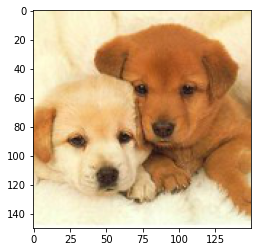

In [ ]:
img_ = Image.open(puppy_list[23])
plt.imshow(img_)
plt.show()

In [ ]:
print(total_data[611])
print(total_data[611][44:47])

/content/drive/MyDrive/Colab Notebooks/data/pup/531189149.jpg
pup


#### Make Dataset

In [ ]:
# make dataset
class K9nF9(data.Dataset):
  def __init__(self, file_list, transform=None, phase="train"):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):

    img_path = self.file_list[index]
    img = Image.open(img_path)
    if len(np.array(img).shape) != 3:
      img = transforms.Grayscale(num_output_channels=3)(img)

    img_transformed = self.transform(
        img, self.phase)

    label = img_path[44:47]

    if label == "dog":
      label = torch.Tensor([0,0])
    elif label == "cat":
      label = torch.Tensor([1,0])
    elif label == "pup":
      label = torch.Tensor([0,1])
    elif label == "kit":
      label = torch.Tensor([1,1])
    
    return img_transformed, label

In [ ]:
train_dataset = K9nF9(
    file_list=total_data[:960], transform=ImageTransform(resize, mean, std), phase="train")
val_dataset = K9nF9(
    file_list=total_data[960:], transform=ImageTransform(resize, mean, std), phase="val")

index = 32
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
tensor([0., 0.])


#### Make Dataloader

In [ ]:
batch_size = 32

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {"train":train_dataloader,  "val":val_dataloader}

batch_iterator = iter(dataloaders_dict["val"])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


#### Install EfficientNet and Change Output Nodes
Two nodes: Cat/Dog-node and Young/Aduls-node

In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=65f6f0856c4128e382940cd7811ed08c9977793a1f64853522d7aa59b90e8782
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
net = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
# change ouput nodes 1000 --> 2
net._fc = nn.Linear(1280, 2)
print("modified:", net._fc)

modified: Linear(in_features=1280, out_features=2, bias=True)


In [ ]:
print(net._fc.weight.size())
print(net._fc.bias.size())

torch.Size([2, 1280])
torch.Size([2])


#### Loss Function

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
params_to_update = []
update_param_names = ["_fc.weight", "_fc.bias"]
print(net.named_parameters())
# net._fc.bias.size()
for name, param in net.named_parameters():
  if name in update_param_names:
    param.requires_grad = True
    params_to_update.append(param)
    print(name)
  else:
    param.requires_grad = False

print(params_to_update)


<generator object Module.named_parameters at 0x7f6e1ca6fe60>
_fc.weight
_fc.bias
[Parameter containing:
tensor([[-0.0111, -0.0073,  0.0035,  ..., -0.0197,  0.0257,  0.0044],
        [ 0.0067,  0.0056, -0.0103,  ..., -0.0265, -0.0170, -0.0002]],
       requires_grad=True), Parameter containing:
tensor([0.0029, 0.0172], requires_grad=True)]


#### Optimizer

In [ ]:
optimizer = optim.SGD(params=params_to_update, lr=0.0005, momentum=0.9) #params=params_to_update)

#### Training (redundant)

In [ ]:
record_loss_train = []
record_loss_test = []
record_acc_train = []
record_acc_test = []

def calc_acc(pred, label):
  return pred.eq(label).sum().numpy()/len(pred)

def training(net, dataloaders_dict, criterion, optimizer, num_epochs):
  net.to("cuda:0")
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("-----------------")
    # train
    net.train()
    # volatile = False
    loss_train = 0.0

    for j, (inputs, labels) in enumerate(dataloaders_dict["train"]):
      inputs, labels = inputs.cuda(), labels.cuda()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss_train += loss.item()
      predictions = torch.round(nn.Sigmoid()(outputs))
      acc_list = []
      for j, row in enumerate(predictions):
        acc = calc_acc(torch.Tensor.cpu(row), torch.Tensor.cpu(labels[j]))
        acc_list.append(acc)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_train /= j+1
    acc_train = np.asarray(acc_list).mean()
    record_loss_train.append(loss_train)
    record_acc_train.append(acc_train)

    # eval
    net.eval()
    # volatile = True
    loss_test = 0.0
    
    for j, (inputs_test, labels_test) in enumerate(dataloaders_dict["val"]):
      inputs_test, labels_test = inputs_test.cuda(), labels_test.cuda()
      outputs_test = net(inputs_test)
      loss = criterion(outputs_test, labels_test)
      loss_test += loss.item()
      predictions_test = torch.round(nn.Sigmoid()(outputs_test))
      acc_list_test = []
      for j, row in enumerate(predictions_test):
        acc_t = calc_acc(torch.Tensor.cpu(row), torch.Tensor.cpu(labels[j]))
        acc_list_test.append(acc_t)
    loss_test /= j+1
    acc_test = np.asarray(acc_list_test).mean()
    record_loss_test.append(loss_train)
    record_acc_test.append(acc_train)

    if epoch%1 == 0:
      print("Epoch:", epoch+1, "\n", "Loss_Train:", loss_train, "Loss_Test:", loss_test, "\n",\
            "Acc_Train:", acc_train, "Acc_Test:", acc_test)


#### Train
Train and test accuracy are approx 0.7 to 0.8 (unstable learning)

In [ ]:
num_epochs = 100

training(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

#### Save Parameters

In [ ]:
torch.save(net.state_dict(), "/content/drive/MyDrive/efficient1204.pth")